In [125]:
%matplotlib inline
#%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
import moviepy.editor as mpy
from moviepy.video.io.bindings import mplfig_to_npimage
from scipy.ndimage.filters import convolve
from IPython.display import HTML

#dati iniziali

#alpha, beta, gamma, delta, chi, nu, cos21, cos31, cos32, sin21, sin31, sin32 = symbols(u'α β γ δ χ ν c(21) c(31) c(32) s(21) s(31) s(32) ')
punti = 500000
tempo_iniziale = 0
tempo_simulazione = 5

g = 9.81

l1, l2, l3 = (1, 1, 1)
m1, m2, m3 = (1, 1, 1)

# condizioni iniziali
theta0_1, theta0_2, theta0_3 =  (45*2*np.pi / 360 ,1*2*np.pi / 360 ,1*2*np.pi / 360)
w0_1, w0_2, w0_3 = ( 0, 0, 0 )
u0 = (theta0_1, theta0_2, theta0_3, w0_1, w0_2, w0_3)

theta_1, theta_2, theta_3 = np.zeros(punti) , np.zeros(punti), np.zeros(punti)
w1, w2, w3 = np.zeros(punti) , np.zeros(punti), np.zeros(punti)

theta_1[0], theta_2[0], theta_3[0] = theta0_1, theta0_2, theta0_3
w1[0], w2[0], w3[0] = w0_1, w0_2, w0_3



In [126]:
def stormer_verlet(f, u0, t0, tf, n):
    t = np.linspace(t0, tf, n+1)
    th1, th2, th3 = np.array([u0[0]]), np.array([u0[1]]), np.array([u0[2]])
    w1 , w2, w3 = np.array([u0[3]]), np.array([u0[4]]), np.array([u0[5]])
    h = t[1]-t[0]
    y_0 = np.array([th1[0], th2[0], th3[0], w1[0], w2[0], w3[0]])
    y_1 = y_0[0:3] + y_0[3:6]*h + f(y_0, t[0])[3:6]*h*h/2
    th1 = np.append(th1, [y_1[0]])
    th2 = np.append(th2, [y_1[1]])
    th3 = np.append(th3, [y_1[2]])
    # integrazione dx per ottenere y_1 errore O(h)
    w1_1 = (y_1[0] - y_0[0])/h
    w2_1 = (y_1[1] - y_0[1])/h
    w3_1 = (y_1[2] - y_0[2])/h
    w1 = np.append(w1, [w1_1])
    w2 = np.append(w2, [w2_1])
    w3 = np.append(w3, [w3_1])    
    
    for i in range(1, n):
        y_i = np.array([th1[i], th2[i], th3[i], w1[i], w2[i], w3[i]])
        y_im1 = np.array([th1[i-1], th2[i-1], th3[i-1], w1[i-1], w2[i-1], w3[i-1]])
        r_ip1 = 2*y_i[0:3] - y_im1[0:3]  + f(y_i, t[i])[3:6]*h*h 
        w_ip1 = (r_ip1[0:3] - y_i[0:3])/h

        th1 = np.append(th1, [r_ip1[0]])
        th2 = np.append(th2, [r_ip1[1]])
        th3 = np.append(th3, [r_ip1[2]])
        w1 = np.append(w1, [w_ip1[0]])
        w2 = np.append(w2, [w_ip1[1]])
        w3 = np.append(w3, [w_ip1[2]])
            
    return (th1, th2, th3 ,w1 , w2 , w3 , t)



def velocity_verlet(f, u0, t0, tf, n):
    t = np.linspace(t0, tf, n+1)
    th1, th2, th3 = np.array([u0[0]]), np.array([u0[1]]), np.array([u0[2]])
    w1 , w2, w3 = np.array([u0[3]]), np.array([u0[4]]), np.array([u0[5]])
    h = t[1]-t[0]
    s = 1e-14
    for i in range(n):
        y_i = np.array([th1[i], th2[i], th3[i], w1[i], w2[i], w3[i]])
        y_ip1 = np.array([th1[i], th2[i], th3[i], w1[i], w2[i], w3[i]])
        y_ip1[0:3] = y_i[0:3] + y_i[3:6]*h  + f(y_i, t[i])[3:6]*h*h/2        
        diff = [2*s, 2*s, 2*s]
        p = 0
        # "y_0" prima stima
        y_ip1[3:6] = y_i[3:6] + f(y_i, t[i])[3:6]*h/2
        c = [0, 0 , 0, 0, 0, 0]
        while (np.abs(diff[0]) > s or np.abs(diff[1]) > s or np.abs(diff[2]) > s) :
            diff = c[3:6]
            c =  f(y_ip1 + c, t[i])*h/2
            diff -= c[3:6]
            p += 1
            #print(p)
            
        y_ip1[3:6]+=c[3:6]
        #print(y_ip1)
        th1 = np.append(th1, [y_ip1[0]])
        th2 = np.append(th2, [y_ip1[1]])
        th3 = np.append(th3, [y_ip1[2]])
        w1 = np.append(w1, [y_ip1[3]])
        w2 = np.append(w2, [y_ip1[4]])
        w3 = np.append(w3, [y_ip1[5]])
            
    return (th1, th2, th3 ,w1 , w2 , w3 , t)



def eulero_implicito(f, u0, t0, tf, n):
    t = np.linspace(t0, tf, n+1)
    th1, th2, th3 = np.array([u0[0]]), np.array([u0[1]]), np.array([u0[2]])
    w1 , w2, w3 = np.array([u0[3]]), np.array([u0[4]]), np.array([u0[5]])
    h = t[1]-t[0]
    s = 1e-16
    for i in range(n):
        y_i = np.array([th1[i], th2[i], th3[i], w1[i], w2[i], w3[i]])
        y_ip1 = y_i
        p = 0
        # "y_0" prima stima
        c = [0, 0 , 0, 0, 0, 0]
        diff = [2*s, 2*s, 2*s, 2*s, 2*s, 2*s]

        while (np.abs(diff[0]) > s or np.abs(diff[1]) > s or np.abs(diff[2]) > s or np.abs(diff[3]) > s or np.abs(diff[4]) > s or np.abs(diff[5]) > s) :
            diff = c
            c =  f(y_ip1 + c, t[i])*h
            diff -= c
            p += 1
            print(p)
            print(diff)
            
        y_ip1+=c
            
        print(y_ip1)
        th1 = np.append(th1, [y_ip1[0]])
        th2 = np.append(th2, [y_ip1[1]])
        th3 = np.append(th3, [y_ip1[2]])
        w1 = np.append(w1, [y_ip1[3]])
        w2 = np.append(w2, [y_ip1[4]])
        w3 = np.append(w3, [y_ip1[5]])
            
    return (th1, th2, th3 ,w1 , w2 , w3 , t)
 
def eulero_simplettico(f, u0, t0, tf , n):
    t = np.linspace(t0, tf, n+1)
    th1, th2, th3 = np.array([u0[0]]), np.array([u0[1]]), np.array([u0[2]])
    w1 , w2, w3 = np.array([u0[3]]), np.array([u0[4]]), np.array([u0[5]])
    
    h = t[1]-t[0]
    
    for i in range(n):
        y_i = np.array([th1[i], th2[i], th3[i], w1[i], w2[i], w3[i]])
        y_i[3:6] += f(y_i , t[i])[3:6]*h
        y_i[0:3] += f(y_i , t[i])[0:3]*h

        if np.any(np.isnan(y_i)):
            print("Eulero semi-implicito NaN al passo " + str(i) + "  Cioè a t = " + str(i*h) + " Secondi" )
            return (th1, th2, th3 ,w1 , w2 , w3 , t)
        else:
            th1 = np.append(th1, [y_i[0]])
            th2 = np.append(th2, [y_i[1]])
            th3 = np.append(th3, [y_i[2]])
            w1 = np.append(w1, [y_i[3]])
            w2 = np.append(w2, [y_i[4]])
            w3 = np.append(w3, [y_i[5]])
            
    return (th1, th2, th3 ,w1 , w2 , w3 , t)


def runge_kutta4(f, u0, t0, tf , n):
    t = np.linspace(t0, tf, n+1)
    th1, th2, th3 = np.array([u0[0]]), np.array([u0[1]]), np.array([u0[2]])
    w1 , w2, w3 = np.array([u0[3]]), np.array([u0[4]]), np.array([u0[5]])
    
    h = t[1]-t[0]
    
    for i in range(n):
        y_i = np.array([th1[i], th2[i], th3[i], w1[i], w2[i], w3[i]])
        k1 = f(y_i, t[i])*h
        k2 = f(y_i + k1/2, t[i]+h/2)*h
        k3 = f(y_i + k2/2 , t[i] + h/2)*h
        k4 = f(y_i + k3 , t[i] + h)*h
        add = (y_i + (k1 + 2*k2 + 2*k3 + k4)/6.0)
        
        if np.any(np.isnan(add)):
            print("RK - NaN al passo " + str(i) + "  Cioè a t = " + str(i*h) + " Secondi" )
            return (th1, th2, th3 ,w1 , w2 , w3 , t)
        else:
            th1, th2, th3  = np.append(th1, [add[0]]), np.append(th2, [add[1]]), np.append(th3, [add[2]])
            w1 , w2, w3 = np.append(w1, [add[3]]), np.append(w2, [add[4]]), np.append(w3, [add[5]])
            
    return (th1, th2, th3 ,w1 , w2 , w3 , t)


def eulero_esplicito(f, u0, t0, tf , n):
    t = np.linspace(t0, tf, n+1)
    th1, th2, th3 = np.array([u0[0]]), np.array([u0[1]]), np.array([u0[2]])
    w1 , w2, w3 = np.array([u0[3]]), np.array([u0[4]]), np.array([u0[5]])
    
    h = t[1]-t[0]
    
    for i in range(n):
        y_i = np.array([th1[i], th2[i], th3[i], w1[i], w2[i], w3[i]])
        add = (y_i + f(y_i , t[i])*h)
        
        if np.any(np.isnan(add)):
            print("Eulero Esplicito NaN al passo " + str(i) + "  Cioè a t = " + str(i*h) + " Secondi" )
            return (th1, th2, th3 ,w1 , w2 , w3 , t)
        else:
            th1 = np.append(th1, [add[0]])
            th2 = np.append(th2, [add[1]])
            th3 = np.append(th3, [add[2]])
            w1 = np.append(w1, [add[3]])
            w2 = np.append(w2, [add[4]])
            w3 = np.append(w3, [add[5]])
            
    return (th1, th2, th3 ,w1 , w2 , w3 , t)


def f_triple( u , t ):
    theta_1, theta_2, theta_3 = u[0], u[1], u[2]
    w1, w2, w3 = u[3], u[4], u[5]

    theta_21 = theta_2 - theta_1
    theta_31 = theta_3 - theta_1
    theta_32 = theta_3 - theta_2

    cos_21, cos_31, cos_32 = (np.cos(theta_21), np.cos(theta_31), np.cos(theta_32))
    sin_21, sin_31, sin_32 = (np.sin(theta_21), np.sin(theta_31), np.sin(theta_32))
    sin_1, sin_2, sin_3 = (np.sin(theta_1), np.sin(theta_2), np.sin(theta_3))
    cos_1, cos_2, cos_3 = (np.cos(theta_1), np.cos(theta_2), np.cos(theta_3))

    dw1 = (m3*(g*sin_3 + l1*w1**2*(cos_1*sin_3 - cos_3*sin_1) + l2*w2**2*(cos_2*sin_3 - cos_3*sin_2))*(cos_21*cos_32*m2 + cos_21*cos_32*m3 - cos_31*m2 - cos_31*m3) - (cos_21*m2 + cos_21*m3 - cos_31*cos_32*m3)*(g*m2*sin_2 + g*m3*sin_2 + l1*m2*w1**2*(cos_1*sin_2 - cos_2*sin_1) + l1*m3*w1**2*(cos_1*sin_2 - cos_2*sin_1) - l3*m3*w3**2*(cos_2*sin_3 - cos_3*sin_2)) + (-cos_32**2*m3 + m2 + m3)*(g*m1*sin_1 + g*m2*sin_1 + g*m3*sin_1 - l2*m2*w2**2*(cos_1*sin_2 - cos_2*sin_1) - l2*m3*w2**2*(cos_1*sin_2 - cos_2*sin_1) - l3*m3*w3**2*(cos_1*sin_3 - cos_3*sin_1)))/(l1*(cos_21**2*m2**2 + 2*cos_21**2*m2*m3 + cos_21**2*m3**2 - 2*cos_21*cos_31*cos_32*m2*m3 - 2*cos_21*cos_31*cos_32*m3**2 + cos_31**2*m2*m3 + cos_31**2*m3**2 + cos_32**2*m1*m3 + cos_32**2*m2*m3 + cos_32**2*m3**2 - m1*m2 - m1*m3 - m2**2 - 2*m2*m3 - m3**2))
    
    dw2 = (-m3*(g*sin_3 + l1*w1**2*(cos_1*sin_3 - cos_3*sin_1) + l2*w2**2*(cos_2*sin_3 - cos_3*sin_2))*(-cos_21*cos_31*m2 - cos_21*cos_31*m3 + cos_32*m1 + cos_32*m2 + cos_32*m3) - (cos_21*m2 + cos_21*m3 - cos_31*cos_32*m3)*(g*m1*sin_1 + g*m2*sin_1 + g*m3*sin_1 - l2*m2*w2**2*(cos_1*sin_2 - cos_2*sin_1) - l2*m3*w2**2*(cos_1*sin_2 - cos_2*sin_1) - l3*m3*w3**2*(cos_1*sin_3 - cos_3*sin_1)) + (-cos_31**2*m3 + m1 + m2 + m3)*(g*m2*sin_2 + g*m3*sin_2 + l1*m2*w1**2*(cos_1*sin_2 - cos_2*sin_1) + l1*m3*w1**2*(cos_1*sin_2 - cos_2*sin_1) - l3*m3*w3**2*(cos_2*sin_3 - cos_3*sin_2)))/(l2*(cos_21**2*m2**2 + 2*cos_21**2*m2*m3 + cos_21**2*m3**2 - 2*cos_21*cos_31*cos_32*m2*m3 - 2*cos_21*cos_31*cos_32*m3**2 + cos_31**2*m2*m3 + cos_31**2*m3**2 + cos_32**2*m1*m3 + cos_32**2*m2*m3 + cos_32**2*m3**2 - m1*m2 - m1*m3 - m2**2 - 2*m2*m3 - m3**2))
    
    dw3 = ((g*sin_3 + l1*w1**2*(cos_1*sin_3 - cos_3*sin_1) + l2*w2**2*(cos_2*sin_3 - cos_3*sin_2))*(-cos_21**2*m2**2 - 2*cos_21**2*m2*m3 - cos_21**2*m3**2 + m1*m2 + m1*m3 + m2**2 + 2*m2*m3 + m3**2) + (cos_21*cos_32*m2 + cos_21*cos_32*m3 - cos_31*m2 - cos_31*m3)*(g*m1*sin_1 + g*m2*sin_1 + g*m3*sin_1 - l2*m2*w2**2*(cos_1*sin_2 - cos_2*sin_1) - l2*m3*w2**2*(cos_1*sin_2 - cos_2*sin_1) - l3*m3*w3**2*(cos_1*sin_3 - cos_3*sin_1)) - (-cos_21*cos_31*m2 - cos_21*cos_31*m3 + cos_32*m1 + cos_32*m2 + cos_32*m3)*(g*m2*sin_2 + g*m3*sin_2 + l1*m2*w1**2*(cos_1*sin_2 - cos_2*sin_1) + l1*m3*w1**2*(cos_1*sin_2 - cos_2*sin_1) - l3*m3*w3**2*(cos_2*sin_3 - cos_3*sin_2)))/(l3*(cos_21**2*m2**2 + 2*cos_21**2*m2*m3 + cos_21**2*m3**2 - 2*cos_21*cos_31*cos_32*m2*m3 - 2*cos_21*cos_31*cos_32*m3**2 + cos_31**2*m2*m3 + cos_31**2*m3**2 + cos_32**2*m1*m3 + cos_32**2*m2*m3 + cos_32**2*m3**2 - m1*m2 - m1*m3 - m2**2 - 2*m2*m3 - m3**2))
    
    return np.array([ w1, w2, w3 , dw1, dw2, dw3])


def f_double( u , t ):
    theta_1, theta_2 = u[0], u[1]
    w1, w2, w3 = u[3], u[4], 0

    theta_12 = theta_1 - theta_2

    cos_12 = np.cos(theta_12)
    sin_12 = np.sin(theta_12)
    sin_1, sin_2 = (np.sin(theta_1), np.sin(theta_2))
    cos_1, cos_2 = (np.cos(theta_1), np.cos(theta_2))

    dw1 = (-sin_12*(m2*l1*w1**2 * cos_12 + m2*l2*w2**2) - g*((m1+m2)*sin_1 - m2*sin_2 * cos_12))/(l1*(m1 + m2* sin_12**2))
    dw2 = (sin_12 * ((m1+m2)*l1*w1**2 + m2*l2*w2**2 * cos_12) + g*((m1+m2)*sin_1 * cos_12 - (m1+m2)*sin_2))/(l2*(m1+m2*sin_12**2))   
    dw3 = 0
    
    return np.array([ w1, w2, w3 , dw1, dw2, dw3])


def f_single( u , t ):
    theta_1 = u[0]
    w1, w2, w3 = u[3], 0, 0
      
    dw1 = -g/l1 * np.sin(theta_1)
    
    dw2 = 0
    
    dw3 = 0
    
    return np.array([ w1, w2, w3 , dw1, dw2, dw3])


def get_xy_coords(q):
    x1 = l1*np.sin(q[0])
    x2 = l2*np.sin(q[1]) + x1
    x3 = l3 * np.sin(q[2]) + x2
    y1 = -l1*np.cos(q[0]) 
    y2 = -l2*np.cos(q[1]) + y1 
    y3 = -l3 * np.cos(q[2]) + y2
    x = (x1, x2, x3)
    y = (y1, y2, y3)
    return x, y 

def get_polar_coords(p):
    x,y = get_xy_coords(p)
    r1 = np.sqrt(x[0]*x[0] + y[0]*y[0])
    r2 = np.sqrt(x[1]*x[1] + y[1]*y[1])
    r3 = np.sqrt(x[2]*x[2] + y[2]*y[2])
    return (p[0], p[1], p[2]), (r1, r2, r3)


def get_xy_velocity(p):
    dx1 = -l1*np.cos(p[0])*p[3]
    dx2 = -l2*np.cos(p[1])*p[4] + dx1
    dx3 = -l3 * np.cos(p[2])*p[5] + dx2
    dy1 = -l1*np.sin(p[0])*p[3]
    dy2 = -l2*np.sin(p[1])*p[4] + dy1 
    dy3 = -l3 * np.sin(p[2])*p[5] + dy2
    return (dx1, dx2, dx3), (dy1, dy2, dy3)

def energia_cinetica(p):
    dx, dy = get_xy_velocity(p)
    dx1 = -l1*np.cos(p[0])*p[3]
    dx2 = -l2*np.cos(p[1])*p[4] + dx1
    dx3 = -l3 * np.cos(p[2])*p[5] + dx2
    dy1 = -l1*np.sin(p[0])*p[3] 
    dy2 =  -l2*np.sin(p[1])*p[4] + dy1 
    dy3 = -l3 * np.sin(p[2])*p[5] + dy2
    ek = (dx[0]**2 + dx[1]**2 + dx[2]**2 + dy[0]**2 + dy[1]**2 + dy[2]**2)/2.
    return ek

def energia_potenziale(p):
    x, y = get_xy_coords(p)
    ep = g*(m1*y[0]+m2*y[1]+m3*y[2])
    return ep

def energia_totale(p):
    return energia_cinetica(p) + energia_potenziale(p)
    
def plot_pendulum(x, y):
    zeros = np.zeros(np.shape(np.atleast_2d(x[0]).T))
    x = np.hstack([zeros, np.atleast_2d(x[0]).T, np.atleast_2d(x[1]).T, np.atleast_2d(x[2]).T])
    y = np.hstack([zeros, np.atleast_2d(y[0]).T, np.atleast_2d(y[1]).T, np.atleast_2d(y[2]).T])
    return x, y

#def distanza_2d(x,y):
#    return ((x[0] - x[1])**2 + (y[0] - y[1])**2)**(1/2.)


In [127]:
def animate_triple_pendulum(f, output):
    t = np.linspace(tempo_iniziale, tempo_simulazione, punti)
    vett = f(f_triple, u0, tempo_iniziale, tempo_simulazione, punti)
    x, y = get_xy_coords(vett)
    xplot, yplot = plot_pendulum(x,y)
    theta, r = get_polar_coords(vett)
    en_tot = energia_totale(vett)
#   en_tot = en_tot
    fps= punti/(tempo_simulazione-tempo_iniziale)
    fig = plt.figure()
    ax_pend = plt.subplot(331)
#                            gridspec_kw={
#                           'width_ratios': [2, 1, 1],
#                           'height_ratios': [2, 1, 1]})
    ax_polar = fig.add_subplot(332, projection='polar')
    ax_3d = fig.add_subplot(333, projection='3d')
    ax_en_tot = fig.add_subplot(334)
    ax_en_k_p = fig.add_subplot(335)


    ax_pend.set_aspect('equal', adjustable='box')
    ax_pend.axis('off')
    ax_pend.set(xlim=(-(l1+l2+l3)*1.2, (l1+l2+l3)*1.2), ylim=(-(l1+l2+l3)*1.2, (l1+l2+l3)*1.2))
    
    line, = ax_pend.plot([], [], 'o-', lw=2)    
    time_text = ax_pend.text(0.02, 0.95, '', transform=ax_pend.transAxes)
    energy_text = ax_pend.text(0.02, 0.90, '', transform=ax_pend.transAxes)

    
#    fig = plt.figure()

    # to change size of subplot's
    # set height of each subplot as 8
    fig.set_figheight(8)
 
    # set width of each subplot as 8
    fig.set_figwidth(8)
 
    def init():
        line.set_data([], [])
        time_text.set_text('')
        energy_text.set_text('')
        return line, time_text, energy_text

    def animate(i):
        i = int(i*fps)
        line.set_data(xplot[i], yplot[i])
        time_text.set_text('time = %.1f' % ((tempo_simulazione-tempo_iniziale)*i/punti))
        energy_text.set_text('energy = %.9f J' % en_tot[i])
        ax_3d.clear()
        
        ax_3d.plot((r[0]*np.sin(theta[0]))[0:i], (r[0]*np.cos(theta[0]))[0:i], t[0:i])
        ax_3d.plot((r[1]*np.sin(theta[1]))[0:i], (r[1]*np.cos(theta[1]))[0:i], t[0:i])
        ax_3d.plot((r[2]*np.sin(theta[2]))[0:i], (r[2]*np.cos(theta[2]))[0:i], t[0:i])

        ax_polar.clear()

        ax_polar.plot(theta[0][0:i], r[0][0:i])
        ax_polar.plot(theta[1][0:i], r[1][0:i])
        ax_polar.plot(theta[2][0:i], r[2][0:i])

        ax_en_tot.clear()
        ax_en_tot.plot(t[0:i], energia_totale(vett)[0:i], label='Energia Totale')
        ax_en_k_p.clear()
        ax_en_k_p.plot(t[0:i], energia_cinetica(vett)[0:i], label='Energia Cinetica')
        ax_en_k_p.plot(t[0:i], energia_potenziale(vett)[0:i], label='Energia Potenziale')
        return mplfig_to_npimage(fig)
    
    duration = tempo_simulazione - tempo_iniziale
    animation = mpy.VideoClip(animate, duration=duration)
   # animation.write_gif('matplotlib.gif', fps= fps)
    animation.write_videofile(output, fps = fps/1000 )
   # animation.ipython_display(fps= fps, loop=True, autoplay=True)
   #cmap='hsv'

    return animation

def animate_double_pendulum(f, output):
    t = np.linspace(tempo_iniziale, tempo_simulazione, punti)
    vett = f(f_double, u0, tempo_iniziale, tempo_simulazione, punti)
    x, y = get_xy_coords(vett)
    xplot, yplot = plot_pendulum(x,y)
    theta, r = get_polar_coords(vett)
    en_tot = energia_totale(vett)
#   en_tot = en_tot
    fps= punti/(tempo_simulazione-tempo_iniziale)
    fig = plt.figure()
    ax_pend = plt.subplot(331)
#                            gridspec_kw={
#                           'width_ratios': [2, 1, 1],
#                           'height_ratios': [2, 1, 1]})
    ax_polar = fig.add_subplot(332, projection='polar')
    ax_3d = fig.add_subplot(333, projection='3d')
    ax_en_tot = fig.add_subplot(334)
    ax_en_k_p = fig.add_subplot(335)


    ax_pend.set_aspect('equal', adjustable='box')
    ax_pend.axis('off')
    ax_pend.set(xlim=(-(l1+l2)*1.2, (l1+l2)*1.2), ylim=(-(l1+l2)*1.2, (l1+l2)*1.2))
    
    line, = ax_pend.plot([], [], 'o-', lw=2)    
    time_text = ax_pend.text(0.02, 0.95, '', transform=ax_pend.transAxes)
    energy_text = ax_pend.text(0.02, 0.90, '', transform=ax_pend.transAxes)

    
#    fig = plt.figure()

    # to change size of subplot's
    # set height of each subplot as 8
    fig.set_figheight(8)
 
    # set width of each subplot as 8
    fig.set_figwidth(8)
 
    def init():
        line.set_data([], [])
        time_text.set_text('')
        energy_text.set_text('')
        return line, time_text, energy_text

    def animate(i):
        i = int(i*fps)
        line.set_data(xplot[i], yplot[i])
        time_text.set_text('time = %.1f' % ((tempo_simulazione-tempo_iniziale)*i/punti))
        energy_text.set_text('energy = %.9f J' % en_tot[i])
        ax_3d.clear()
        
        ax_3d.plot((r[0]*np.sin(theta[0]))[0:i], (r[0]*np.cos(theta[0]))[0:i], t[0:i])
        ax_3d.plot((r[1]*np.sin(theta[1]))[0:i], (r[1]*np.cos(theta[1]))[0:i], t[0:i])

        ax_polar.clear()

        ax_polar.plot(theta[0][0:i], r[0][0:i])
        ax_polar.plot(theta[1][0:i], r[1][0:i])

        ax_en_tot.clear()
        ax_en_tot.plot(t[0:i], energia_totale(vett)[0:i], label='Energia Totale')
        ax_en_k_p.clear()
        ax_en_k_p.plot(t[0:i], energia_cinetica(vett)[0:i], label='Energia Cinetica')
        ax_en_k_p.plot(t[0:i], energia_potenziale(vett)[0:i], label='Energia Potenziale')
        return mplfig_to_npimage(fig)
    
    duration = tempo_simulazione - tempo_iniziale
    animation = mpy.VideoClip(animate, duration=duration)
   # animation.write_gif('matplotlib.gif', fps= fps)
    animation.write_videofile(output, fps = fps/1000 )
   # animation.ipython_display(fps= fps, loop=True, autoplay=True)
   #cmap='hsv'

    return animation

def animate_single_pendulum(f, output):
    t = np.linspace(tempo_iniziale, tempo_simulazione, punti)
    vett = f(f_single, u0, tempo_iniziale, tempo_simulazione, punti)
    x, y = get_xy_coords(vett)
    xplot, yplot = plot_pendulum(x,y)
    theta, r = get_polar_coords(vett)
    en_tot = energia_totale(vett)
#   en_tot = en_tot
    fps= punti/(tempo_simulazione-tempo_iniziale)
    fig = plt.figure()
    ax_pend = plt.subplot(331)
#                            gridspec_kw={
#                           'width_ratios': [2, 1, 1],
#                           'height_ratios': [2, 1, 1]})
    ax_polar = fig.add_subplot(332, projection='polar')
    ax_3d = fig.add_subplot(333, projection='3d')
    ax_en_tot = fig.add_subplot(334)
    ax_en_k_p = fig.add_subplot(335)


    ax_pend.set_aspect('equal', adjustable='box')
    ax_pend.axis('off')
    ax_pend.set(xlim=(-(l1)*1.2, (l1)*1.2), ylim=(-(l1)*1.2, (l1)*1.2))
    
    line, = ax_pend.plot([], [], 'o-', lw=2)    
    time_text = ax_pend.text(0.02, 0.95, '', transform=ax_pend.transAxes)
    energy_text = ax_pend.text(0.02, 0.90, '', transform=ax_pend.transAxes)

    
#    fig = plt.figure()

    # to change size of subplot's
    # set height of each subplot as 8
    fig.set_figheight(8)
 
    # set width of each subplot as 8
    fig.set_figwidth(8)
 
    def init():
        line.set_data([], [])
        time_text.set_text('')
        energy_text.set_text('')
        return line, time_text, energy_text

    def animate(i):
        i = int(i*fps)
        line.set_data(xplot[i], yplot[i])
        time_text.set_text('time = %.1f' % ((tempo_simulazione-tempo_iniziale)*i/punti))
        energy_text.set_text('energy = %.9f J' % en_tot[i])
        ax_3d.clear()
        
        ax_3d.plot((r[0]*np.sin(theta[0]))[0:i], (r[0]*np.cos(theta[0]))[0:i], t[0:i])
        ax_3d.plot((r[1]*np.sin(theta[1]))[0:i], (r[1]*np.cos(theta[1]))[0:i], t[0:i])

        ax_polar.clear()

        ax_polar.plot(theta[0][0:i], r[0][0:i])
        ax_polar.plot(theta[1][0:i], r[1][0:i])

        ax_en_tot.clear()
        ax_en_tot.plot(t[0:i], energia_totale(vett)[0:i], label='Energia Totale')
        ax_en_k_p.clear()
        ax_en_k_p.plot(t[0:i], energia_cinetica(vett)[0:i], label='Energia Cinetica')
        ax_en_k_p.plot(t[0:i], energia_potenziale(vett)[0:i], label='Energia Potenziale')
        return mplfig_to_npimage(fig)
    
    duration = tempo_simulazione - tempo_iniziale
    animation = mpy.VideoClip(animate, duration=duration)
   # animation.write_gif('matplotlib.gif', fps= fps)
    animation.write_videofile(output, fps = fps/100 )
   # animation.ipython_display(fps= fps, loop=True, autoplay=True)
   #cmap='hsv'

    return animation

Moviepy - Building video eulero_simplettico.mp4.
Moviepy - Writing video eulero_simplettico.mp4



Moviepy - Done !
Moviepy - video ready eulero_simplettico.mp4


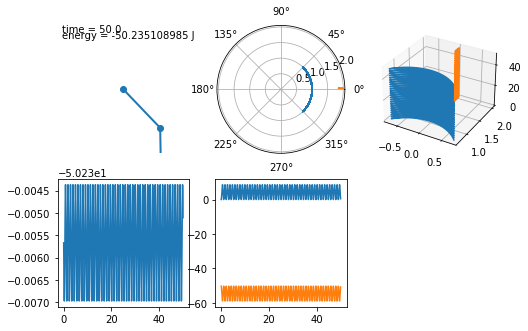

In [114]:
anim_pend = animate_single_pendulum(eulero_simplettico, "eulero_simplettico.mp4")


Moviepy - Building video eulero_simplettico_triplo.mp4.
Moviepy - Writing video eulero_simplettico_triplo.mp4



Moviepy - Done !
Moviepy - video ready eulero_simplettico_triplo.mp4


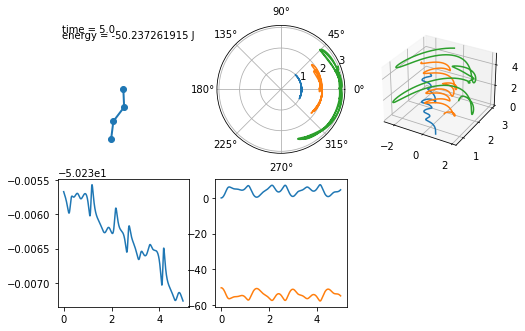

In [128]:
anim_pend = animate_triple_pendulum(eulero_simplettico, "eulero_simplettico_triplo.mp4")


In [96]:
anim_pend = animate_single_pendulum(eulero_implicito, "eulero_implicito.mp4")


1
[0.         0.         0.         0.00693672 0.         0.        ]
2
[6.93671752e-06 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
3
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -4.81182169e-08
  0.00000000e+00  0.00000000e+00]
4
[-4.81182169e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
5
[0.00000000e+00 0.00000000e+00 0.00000000e+00 3.33784216e-13
 0.00000000e+00 0.00000000e+00]
6
[3.33784344e-16 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
7
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.73472348e-18
  0.00000000e+00  0.00000000e+00]
[ 0.78539123  0.01745329  0.01745329 -0.00693667  0.          0.        ]
1
[6.93666941e-06 0.00000000e+00 0.00000000e+00 6.93666941e-03
 0.00000000e+00 0.00000000e+00]
2
[ 6.93666941e-06  0.00000000e+00  0.00000000e+00 -4.81182169e-08
  0.00000000e+00  0.00000000e+00]
3
[-4.81182169e-11  0.00000000e+00  0.00000000e+00 -4.81185507e-08
  0.0

1
[0.00066527 0.         0.         0.00670564 0.         0.        ]
2
[ 6.70564088e-06  0.00000000e+00  0.00000000e+00 -4.76501953e-06
  0.00000000e+00  0.00000000e+00]
3
[-4.76501953e-09  0.00000000e+00  0.00000000e+00 -4.80447281e-08
  0.00000000e+00  0.00000000e+00]
4
[-4.80447281e-11  0.00000000e+00  0.00000000e+00  3.41406270e-11
  0.00000000e+00  0.00000000e+00]
5
[3.41405506e-14 0.00000000e+00 0.00000000e+00 3.44233322e-13
 0.00000000e+00 0.00000000e+00]
6
[ 3.4434261e-16  0.0000000e+00  0.0000000e+00 -2.4459601e-16
  0.0000000e+00  0.0000000e+00]
7
[-3.25260652e-19  0.00000000e+00  0.00000000e+00 -1.73472348e-18
  0.00000000e+00  0.00000000e+00]
[ 0.75194546  0.01745329  0.01745329 -0.67196749  0.          0.        ]
1
[0.00067197 0.         0.         0.00670083 0.         0.        ]
2
[ 6.70082785e-06  0.00000000e+00  0.00000000e+00 -4.81605547e-06
  0.00000000e+00  0.00000000e+00]
3
[-4.81605547e-09  0.00000000e+00  0.00000000e+00 -4.80407055e-08
  0.00000000e+00  0.0000

  0.00000000e+00  0.00000000e+00]
3
[-9.98431377e-09  0.00000000e+00  0.00000000e+00 -4.65904531e-08
  0.00000000e+00  0.00000000e+00]
4
[-4.65904531e-11  0.00000000e+00  0.00000000e+00  7.76237347e-11
  0.00000000e+00  0.00000000e+00]
5
[7.76236714e-14 0.00000000e+00 0.00000000e+00 3.62221537e-13
 0.00000000e+00 0.00000000e+00]
6
[ 3.62123526e-16  0.00000000e+00  0.00000000e+00 -6.02816408e-16
  0.00000000e+00  0.00000000e+00]
7
[-6.50521303e-19  0.00000000e+00  0.00000000e+00 -3.46944695e-18
  0.00000000e+00  0.00000000e+00]
[ 0.6558749   0.01745329  0.01745329 -1.29085144  0.          0.        ]
1
[0.00129085 0.         0.         0.00598266 0.         0.        ]
2
[ 5.98265644e-06  0.00000000e+00  0.00000000e+00 -1.00407951e-05
  0.00000000e+00  0.00000000e+00]
3
[-1.00407951e-08  0.00000000e+00  0.00000000e+00 -4.65588453e-08
  0.00000000e+00  0.00000000e+00]
4
[-4.65588453e-11  0.00000000e+00  0.00000000e+00  7.81406892e-11
  0.00000000e+00  0.00000000e+00]
5
[7.81408358e-14 0.

  0.00000000e+00  0.00000000e+00]
[ 0.51840649  0.01745329  0.01745329 -1.77619747  0.          0.        ]
1
[0.0017762  0.         0.         0.00486082 0.         0.        ]
2
[ 4.86082192e-06  0.00000000e+00  0.00000000e+00 -1.51427498e-05
  0.00000000e+00  0.00000000e+00]
3
[-1.51427498e-08  0.00000000e+00  0.00000000e+00 -4.14613277e-08
  0.00000000e+00  0.00000000e+00]
4
[-4.14613276e-11  0.00000000e+00  0.00000000e+00  1.29163212e-10
  0.00000000e+00  0.00000000e+00]
5
[1.29163390e-13 0.00000000e+00 0.00000000e+00 3.53652871e-13
 0.00000000e+00 0.00000000e+00]
6
[ 3.53449908e-16  0.00000000e+00  0.00000000e+00 -1.10154941e-15
  0.00000000e+00  0.00000000e+00]
7
[-1.08420217e-18  0.00000000e+00  0.00000000e+00 -4.33680869e-18
  0.00000000e+00  0.00000000e+00]
[ 0.51662545  0.01745329  0.01745329 -1.78104311  0.          0.        ]
1
[0.00178104 0.         0.         0.00484564 0.         0.        ]
2
[ 4.84563784e-06  0.00000000e+00  0.00000000e+00 -1.51994525e-05
  0.0000000

1
[0.00213494 0.         0.         0.00333736 0.         0.        ]
2
[ 3.33736134e-06  0.00000000e+00  0.00000000e+00 -1.97021305e-05
  0.00000000e+00  0.00000000e+00]
3
[-1.97021305e-08  0.00000000e+00  0.00000000e+00 -3.08104323e-08
  0.00000000e+00  0.00000000e+00]
4
[-3.08104319e-11  0.00000000e+00  0.00000000e+00  1.81889660e-10
  0.00000000e+00  0.00000000e+00]
5
[1.81889660e-13 0.00000000e+00 0.00000000e+00 2.84440874e-13
 0.00000000e+00 0.00000000e+00]
6
[ 2.84060969e-16  0.00000000e+00  0.00000000e+00 -1.67877864e-15
  0.00000000e+00  0.00000000e+00]
7
[-1.30104261e-18  0.00000000e+00  0.00000000e+00 -3.46944695e-18
  0.00000000e+00  0.00000000e+00]
[ 0.34499125  0.01745329  0.01745329 -2.13825851  0.          0.        ]
1
[0.00213826 0.         0.         0.00331763 0.         0.        ]
2
[ 3.31762858e-06  0.00000000e+00  0.00000000e+00 -1.97479274e-05
  0.00000000e+00  0.00000000e+00]
3
[-1.97479274e-08  0.00000000e+00  0.00000000e+00 -3.06517614e-08
  0.00000000e+00  

[0.00235627 0.         0.         0.00129257 0.         0.        ]
2
[ 1.29256742e-06  0.00000000e+00  0.00000000e+00 -2.29170479e-05
  0.00000000e+00  0.00000000e+00]
3
[-2.29170479e-08  0.00000000e+00  0.00000000e+00 -1.25734395e-08
  0.00000000e+00  0.00000000e+00]
4
[-1.25734397e-11  0.00000000e+00  0.00000000e+00  2.22925422e-10
  0.00000000e+00  0.00000000e+00]
5
[2.22925411e-13 0.00000000e+00 0.00000000e+00 1.22308197e-13
 0.00000000e+00 0.00000000e+00]
6
[ 1.22298005e-16  0.00000000e+00  0.00000000e+00 -2.16840434e-15
  0.00000000e+00  0.00000000e+00]
7
[-2.16840434e-18  0.00000000e+00  0.00000000e+00 -1.30104261e-18
  0.00000000e+00  0.00000000e+00]
[ 0.1297869   0.01745329  0.01745329 -2.35753939  0.          0.        ]
1
[0.00235754 0.         0.         0.00126964 0.         0.        ]
2
[ 1.26963803e-06  0.00000000e+00  0.00000000e+00 -2.29364549e-05
  0.00000000e+00  0.00000000e+00]
3
[-2.29364549e-08  0.00000000e+00  0.00000000e+00 -1.23541619e-08
  0.00000000e+00  0.

[ 0.00237475  0.          0.         -0.00087608  0.          0.        ]
2
[-8.76079769e-07  0.00000000e+00  0.00000000e+00 -2.32007673e-05
  0.00000000e+00  0.00000000e+00]
3
[-2.32007673e-08  0.00000000e+00  0.00000000e+00  8.55815606e-09
  0.00000000e+00  0.00000000e+00]
4
[8.55815592e-12 0.00000000e+00 0.00000000e+00 2.26641230e-10
 0.00000000e+00 0.00000000e+00]
5
[ 2.26641622e-13  0.00000000e+00  0.00000000e+00 -8.36020706e-14
  0.00000000e+00  0.00000000e+00]
6
[-8.37004077e-17  0.00000000e+00  0.00000000e+00 -2.21404926e-15
  0.00000000e+00  0.00000000e+00]
7
[-2.16840434e-18  0.00000000e+00  0.00000000e+00  7.58941521e-19
  0.00000000e+00  0.00000000e+00]
[-0.09179776  0.01745329  0.01745329 -2.37385542  0.          0.        ]
1
[ 0.00237386  0.          0.         -0.00089927  0.          0.        ]
2
[-8.99271751e-07  0.00000000e+00  0.00000000e+00 -2.31869151e-05
  0.00000000e+00  0.00000000e+00]
3
[-2.31869151e-08  0.00000000e+00  0.00000000e+00  8.78276775e-09
  0.0000

[ 0.00218289  0.          0.         -0.00301178  0.          0.        ]
2
[-3.01177588e-06  0.00000000e+00  0.00000000e+00 -2.03727760e-05
  0.00000000e+00  0.00000000e+00]
3
[-2.03727760e-08  0.00000000e+00  0.00000000e+00  2.80987972e-08
  0.00000000e+00  0.00000000e+00]
4
[2.80987972e-11 0.00000000e+00 0.00000000e+00 1.90070844e-10
 0.00000000e+00 0.00000000e+00]
5
[ 1.90071049e-13  0.00000000e+00  0.00000000e+00 -2.62151845e-13
  0.00000000e+00  0.00000000e+00]
6
[-2.62810607e-16  0.00000000e+00  0.00000000e+00 -1.77332107e-15
  0.00000000e+00  0.00000000e+00]
7
[-1.73472348e-18  0.00000000e+00  0.00000000e+00  2.60208521e-18
  0.00000000e+00  0.00000000e+00]
[-0.3142304   0.01745329  0.01745329 -2.17985693  0.          0.        ]
1
[ 0.00217986  0.          0.         -0.00303212  0.          0.        ]
2
[-3.03212037e-06  0.00000000e+00  0.00000000e+00 -2.03300795e-05
  0.00000000e+00  0.00000000e+00]
3
[-2.03300795e-08  0.00000000e+00  0.00000000e+00  2.82685238e-08
  0.0000

[ 0.00179648  0.          0.         -0.00477409  0.          0.        ]
2
[-4.77408607e-06  0.00000000e+00  0.00000000e+00 -1.53880907e-05
  0.00000000e+00  0.00000000e+00]
3
[-1.53880907e-08  0.00000000e+00  0.00000000e+00  4.08727665e-08
  0.00000000e+00  0.00000000e+00]
4
[4.08727665e-11 0.00000000e+00 0.00000000e+00 1.31743474e-10
 0.00000000e+00 0.00000000e+00]
5
[ 1.31743358e-13  0.00000000e+00  0.00000000e+00 -3.49927552e-13
  0.00000000e+00  0.00000000e+00]
6
[-3.49763621e-16  0.00000000e+00  0.00000000e+00 -1.12843762e-15
  0.00000000e+00  0.00000000e+00]
7
[-1.30104261e-18  0.00000000e+00  0.00000000e+00  2.60208521e-18
  0.00000000e+00  0.00000000e+00]
[-0.5100484   0.01745329  0.01745329 -1.79169551  0.          0.        ]
1
[ 0.0017917   0.          0.         -0.00478943  0.          0.        ]
2
[-4.78943315e-06  0.00000000e+00  0.00000000e+00 -1.53317116e-05
  0.00000000e+00  0.00000000e+00]
3
[-1.53317116e-08  0.00000000e+00  0.00000000e+00  4.09631041e-08
  0.0000

1
[ 0.00132276  0.          0.         -0.00590555  0.          0.        ]
2
[-5.90555320e-06  0.00000000e+00  0.00000000e+00 -1.03563777e-05
  0.00000000e+00  0.00000000e+00]
3
[-1.03563777e-08  0.00000000e+00  0.00000000e+00  4.62138828e-08
  0.00000000e+00  0.00000000e+00]
4
[4.62138828e-11 0.00000000e+00 0.00000000e+00 8.10439736e-11
 0.00000000e+00 0.00000000e+00]
5
[ 8.10441124e-14  0.00000000e+00  0.00000000e+00 -3.61647344e-13
  0.00000000e+00  0.00000000e+00]
6
[-3.61689845e-16  0.00000000e+00  0.00000000e+00 -6.34908792e-16
  0.00000000e+00  0.00000000e+00]
7
[-6.50521303e-19  0.00000000e+00  0.00000000e+00  3.46944695e-18
  0.00000000e+00  0.00000000e+00]
[-0.64731177  0.01745329  0.01745329 -1.31684098  0.          0.        ]
1
[ 0.00131684  0.          0.         -0.00591586  0.          0.        ]
2
[-5.91586328e-06  0.00000000e+00  0.00000000e+00 -1.02998246e-05
  0.00000000e+00  0.00000000e+00]
3
[-1.02998246e-08  0.00000000e+00  0.00000000e+00  4.62486455e-08
  0.00

  0.00000000e+00  0.00000000e+00]
6
[-3.46402594e-16  0.00000000e+00  0.00000000e+00 -2.81025203e-16
  0.00000000e+00  0.00000000e+00]
7
[-3.25260652e-19  0.00000000e+00  0.00000000e+00  1.73472348e-18
  0.00000000e+00  0.00000000e+00]
[-0.74194844  0.01745329  0.01745329 -0.73591042  0.          0.        ]
1
[ 0.00073591  0.          0.         -0.00662887  0.          0.        ]
2
[-6.62886707e-06  0.00000000e+00  0.00000000e+00 -5.31992186e-06
  0.00000000e+00  0.00000000e+00]
3
[-5.31992186e-09  0.00000000e+00  0.00000000e+00  4.79042777e-08
  0.00000000e+00  0.00000000e+00]
4
[4.79042777e-11 0.00000000e+00 0.00000000e+00 3.84451498e-11
 0.00000000e+00 0.00000000e+00]
5
[ 3.84452669e-14  0.00000000e+00  0.00000000e+00 -3.46186621e-13
  0.00000000e+00  0.00000000e+00]
6
[-3.46294174e-16  0.00000000e+00  0.00000000e+00 -2.77555756e-16
  0.00000000e+00  0.00000000e+00]
7
[-2.16840434e-19  0.00000000e+00  0.00000000e+00  2.60208521e-18
  0.00000000e+00  0.00000000e+00]
[-0.74267771  

  0.00000000e+00  0.00000000e+00]
6
[-3.35316627e-16  0.00000000e+00  0.00000000e+00 -4.16333634e-17
  0.00000000e+00  0.00000000e+00]
7
[-4.06575815e-20  0.00000000e+00  0.00000000e+00  2.60208521e-18
  0.00000000e+00  0.00000000e+00]
[-0.7806314   0.01745329  0.01745329 -0.11694177  0.          0.        ]
1
[ 0.00011694  0.          0.         -0.00690357  0.          0.        ]
2
[-6.90357315e-06  0.00000000e+00  0.00000000e+00 -8.15002335e-07
  0.00000000e+00  0.00000000e+00]
3
[-8.15002335e-10  0.00000000e+00  0.00000000e+00  4.81104542e-08
  0.00000000e+00  0.00000000e+00]
4
[4.81104542e-11 0.00000000e+00 0.00000000e+00 5.67970757e-12
 0.00000000e+00 0.00000000e+00]
5
[ 5.67970150e-15  0.00000000e+00  0.00000000e+00 -3.35279547e-13
  0.00000000e+00  0.00000000e+00]
6
[-3.35262417e-16  0.00000000e+00  0.00000000e+00 -3.98986399e-17
  0.00000000e+00  0.00000000e+00]
7
[-4.06575815e-20  0.00000000e+00  0.00000000e+00  3.46944695e-18
  0.00000000e+00  0.00000000e+00]
[-0.78074144  

2
[-6.77182250e-06  0.00000000e+00  0.00000000e+00  3.65773829e-06
  0.00000000e+00  0.00000000e+00]
3
[3.65773829e-09 0.00000000e+00 0.00000000e+00 4.80887000e-08
 0.00000000e+00 0.00000000e+00]
4
[ 4.80887000e-11  0.00000000e+00  0.00000000e+00 -2.59747579e-11
  0.00000000e+00  0.00000000e+00]
5
[-2.59747735e-14  0.00000000e+00  0.00000000e+00 -3.41493327e-13
  0.00000000e+00  0.00000000e+00]
6
[-3.41523684e-16  0.00000000e+00  0.00000000e+00  1.85615412e-16
  0.00000000e+00  0.00000000e+00]
7
[2.16840434e-19 0.00000000e+00 0.00000000e+00 1.73472348e-18
 0.00000000e+00 0.00000000e+00]
[-0.76137874  0.01745329  0.01745329  0.52197685  0.          0.        ]
1
[-0.00052198  0.          0.         -0.00676812  0.          0.        ]
2
[-6.76811670e-06  0.00000000e+00  0.00000000e+00  3.70764471e-06
  0.00000000e+00  0.00000000e+00]
3
[3.70764471e-09 0.00000000e+00 0.00000000e+00 4.80865977e-08
 0.00000000e+00 0.00000000e+00]
4
[ 4.80865977e-11  0.00000000e+00  0.00000000e+00 -2.634242

[-3.58437238e-16  0.00000000e+00  0.00000000e+00  4.80518403e-16
  0.00000000e+00  0.00000000e+00]
7
[4.33680869e-19 0.00000000e+00 0.00000000e+00 3.46944695e-18
 0.00000000e+00 0.00000000e+00]
[-0.68729905  0.01745329  0.01745329  1.10952399  0.          0.        ]
1
[-0.00110952  0.          0.         -0.00622397  0.          0.        ]
2
[-6.22397186e-06  0.00000000e+00  0.00000000e+00  8.41708520e-06
  0.00000000e+00  0.00000000e+00]
3
[8.4170852e-09 0.0000000e+00 0.0000000e+00 4.7237967e-08 0.0000000e+00
 0.0000000e+00]
4
[ 4.72379672e-11  0.00000000e+00  0.00000000e+00 -6.38831618e-11
  0.00000000e+00  0.00000000e+00]
5
[-6.38833604e-14  0.00000000e+00  0.00000000e+00 -3.58522240e-13
  0.00000000e+00  0.00000000e+00]
6
[-3.58437238e-16  0.00000000e+00  0.00000000e+00  4.84855212e-16
  0.00000000e+00  0.00000000e+00]
7
[4.33680869e-19 0.00000000e+00 0.00000000e+00 3.46944695e-18
 0.00000000e+00 0.00000000e+00]
[-0.68618331  0.01745329  0.01745329  1.11573949  0.          0.    

 0.00000000e+00 0.00000000e+00]
4
[ 4.36875926e-11  0.00000000e+00  0.00000000e+00 -1.10436342e-10
  0.00000000e+00  0.00000000e+00]
5
[-1.10436183e-13  0.00000000e+00  0.00000000e+00 -3.61643007e-13
  0.00000000e+00  0.00000000e+00]
6
[-3.61906685e-16  0.00000000e+00  0.00000000e+00  9.14199272e-16
  0.00000000e+00  0.00000000e+00]
7
[1.08420217e-18 0.00000000e+00 0.00000000e+00 3.46944695e-18
 0.00000000e+00 0.00000000e+00]
[-0.5664246   0.01745329  0.01745329  1.61774149  0.          0.        ]
1
[-0.00161774  0.          0.         -0.00526423  0.          0.        ]
2
[-5.26422722e-06  0.00000000e+00  0.00000000e+00  1.33984224e-05
  0.00000000e+00  0.00000000e+00]
3
[1.33984224e-08 0.00000000e+00 0.00000000e+00 4.36217151e-08
 0.00000000e+00 0.00000000e+00]
4
[ 4.3621715e-11  0.0000000e+00  0.0000000e+00 -1.1102544e-10
  0.0000000e+00  0.0000000e+00]
5
[-1.11025338e-13  0.00000000e+00  0.00000000e+00 -3.61468667e-13
  0.00000000e+00  0.00000000e+00]
6
[-3.61689845e-16  0.000000

KeyboardInterrupt: 

Moviepy - Building video vv_single.mp4.
Moviepy - Writing video vv_single.mp4



Moviepy - Done !
Moviepy - video ready vv_single.mp4


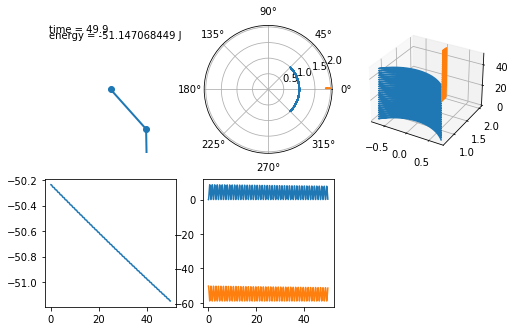

In [97]:
anim_pend = animate_single_pendulum(velocity_verlet, "vv_single.mp4")
#anim_pend = animate_double_pendulum(velocity_verlet, "vv_double.mp4")


In [7]:
anim_pend = animate_triple_pendulum(stormer_verlet, "sv_triple.mp4")

KeyboardInterrupt: 

Moviepy - Building video sv_double.mp4.
Moviepy - Writing video sv_double.mp4



Moviepy - Done !
Moviepy - video ready sv_double.mp4


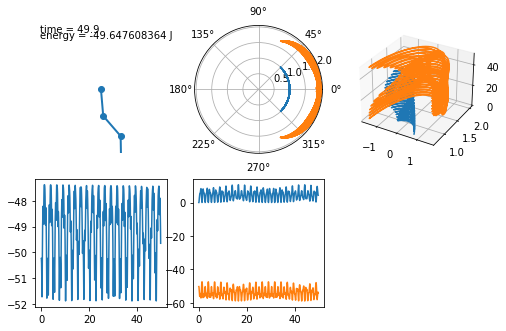

In [101]:
anim_pend = animate_double_pendulum(stormer_verlet, "sv_double.mp4")


Moviepy - Building video sv_single.mp4.
Moviepy - Writing video sv_single.mp4



Moviepy - Done !
Moviepy - video ready sv_single.mp4


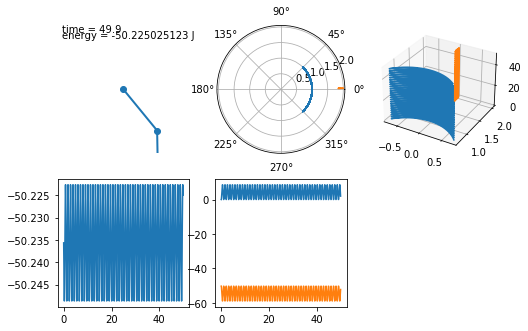

In [98]:
anim_pend = animate_single_pendulum(stormer_verlet, "sv_single.mp4")


In [ ]:
anim_pend = animate_pendulum(runge_kutta4, "rk.mp4")


In [ ]:
anim2_pend= animate_pendulum(eulero_esplicito, "eulero_exp.mp4")

In [ ]:
from scipy.integrate import odeint
t_span = np.linspace(tempo_iniziale, tempo_simulazione, punti)
solution = odeint(f_triple, u0, t_span)

In [ ]:
plt.plot(t_span, solution[:, 0], label='theta1');
plt.plot(t_span, solution[:, 1], label='theta2');
plt.plot(t_span, solution[:, 2], label='theta3');
plt.plot(t_span, solution[:, 3], label='omega1');
plt.plot(t_span, solution[:, 4], label='omega2');
plt.plot(t_span, solution[:, 5], label='omega3');
#print(energia_totale(solution))
plt.legend();

In [ ]:
ris_rk = runge_kutta4(f_suic, u0, tempo_iniziale, tempo_simulazione, punti)
ris_eulero = eulero_esplicito(f_suic, u0, tempo_iniziale, tempo_simulazione, punti)



In [ ]:
#plt.plot(energia_totale(ris_rk)[0:10000])
#plt.plot(energia_totale(ris_eulero)[0:10000])
#plt.plot(energia_totale(ris_rk))
plt.plot(energia_totale(ris_eulero))

In [ ]:
#plt.plot(energia_potenziale(ris_rk)[0:9000])
#plt.plot(energia_potenziale(ris_eulero)[0:9000])
#plt.plot(energia_cinetica(ris_rk)[0:9000])
#plt.plot(energia_cinetica(ris_eulero)[0:9000])
plt.plot(energia_potenziale(ris_rk))
#plt.plot(energia_potenziale(ris_eulero))
plt.plot(energia_cinetica(ris_rk))
#plt.plot(energia_cinetica(ris_eulero))


In [ ]:
fps=punti/(tempo_simulazione-tempo_iniziale)
print("fps: " + str(fps))
anim_pend.ipython_display(fps=punti/(tempo_simulazione-tempo_iniziale), loop=True, autoplay=True)


In [ ]:
plt.plot(energia_totale(ris_rk))
plt.plot(energia_totale(ris_eulero))
#print(energia_totale(ris_rk))
#print(energia_totale(ris_eulero))
#plt.plot(energia_potenziale(ris_rk))
#plt.plot(energia_cinetica(ris_rk))

In [ ]:
HTML(anim2_pend.to_html5_video())

In [ ]:
# importing movie py libraries
#from moviepy.editor import VideoClip


from IPython.display import HTML
#HTML(anim.to_html5_video())

# displaying animation with auto play and looping
#anim_pend.ipython_display(fps = 20, loop = True, autoplay = True)
#anim_pend.write_videofile('test.mp4', fps=20)
HTML(anim_pend.to_html5_video())

In [ ]:
#import moviepy.editor as mpy
#animation = mpy.VideoClip(make_frame, duration=25)
# You can write the result as a gif (veeery slow) or a video:
#animation.write_gif(make_frame, fps=15)
#animation.write_videofile('test.mp4', fps=20)

In [ ]:
anim.save('movie.mp4')

In [ ]:
#plt.plot(energia_potenziale(ris_eulero) )
#plt.plot(energia_cinetica(ris_eulero))

#equazioni del moto
dw1 = -g*l1*m1*sin1 - g*l1*m2*sin1 - g*l1*m3*sin1 + l1*l2*m2*(-sin1*cos2 + sin2*cos1)*w2**2 + l1*l2*m3*(-sin1*cos2 + sin2*cos1)*w2**2 + l1*l3*m3*(-sin1*cos3 + sin3*cos1)*w3**2
dw2 = -g*l2*m2*sin2 - g*l2*m3*sin2 + l1*l2*m2*(sin1*cos2 - sin2*cos1)*w1**2 + l1*l2*m3*(sin1*cos2 - sin2*cos1)*w1**2 + l2*l3*m3*(-sin2*cos3 + sin3*cos2)*w3**2
dw3 = -g*l3*m3*sin3 + l1*l3*m3*(sin1*cos3 - sin3*cos1)*w1**2 + l2*l3*m3*(sin2*cos3 - sin3*cos2)*w2**2


In [ ]:
x= float("nan")
y = 3
if not(np.isnan(x)):
    print(np.isnan(y))

In [ ]:
# roba vecchia
l1_2, l1_3, l2_3 = l1/l2, l1/l3, l2/l3
l2_1, l3_1, l3_2 = 1/l1_2, 1/l1_3, 1/l2_3

M23_123 = (m2 + m3)/(m1 + m2 +m3)
M3_123 = (m3)/(m1 + m2 + m3)
M3_23 = (m3)/(m2 + m3)
M3 = m3
M23 = (m2+m3)
M123 = (m1 + m2 + m3)
alfa, beta, gamma, delta, chi, nu = M23_123*l2_1, M3_123*l3_1, M3_23*l3_2, l1_2, l1_3, l2_3 

theta0_21 = theta0_2 - theta0_1
theta0_31 = theta0_3 - theta0_1
theta0_32 = theta0_3 - theta0_2





def f_1( u , t ):
    theta_1 = u[0]
    theta_2 = u[1]
    theta_3 = u[2]
    w1 = u[3]
    w2 = u[4]
    w3 = u[5]
    
    theta_21 = theta_2 - theta_1
    theta_31 = theta_3 - theta_1
    theta_32 = theta_3 - theta_2

    cos_21, cos_31, cos32 = (np.cos(theta_21), np.cos(theta_31), np.cos(theta_32))
    sin_21, sin_31, sin_32 = (np.sin(theta_21), np.sin(theta_31), np.sin(theta_32))
    sin_1, sin_2, sin_3 = (np.sin(theta_1), np.sin(theta_2), np.sin(theta_3))

    dw1 = (-alfa*cos_21 + beta*cos_31*nu*sin_32)*(-delta*sin_21*w1**2 - g*sin_2/l2 + gamma*sin_32*w3**2)/(alfa*chi*cos_21*cos_31*gamma*sin_32 - alfa*cos_21**2*delta - beta*chi*cos_31**2 + beta*cos_21*cos_31*delta*nu*sin_32 - gamma*nu*sin_32**2 + 1) + (-gamma*nu*sin_32**2 + 1)*(alfa*sin_21*w2**2 + beta*sin_31*w3**2 - g*sin_1/l1)/(alfa*chi*cos_21*cos_31*gamma*sin_32 - alfa*cos_21**2*delta - beta*chi*cos_31**2 + beta*cos_21*cos_31*delta*nu*sin_32 - gamma*nu*sin_32**2 + 1) + (alfa*cos_21*gamma*sin_32 - beta*cos_31)*(-chi*sin_31*w1**2 - g*sin_3/l3 - nu*sin_32*w2**2)/(alfa*chi*cos_21*cos_31*gamma*sin_32 - alfa*cos_21**2*delta - beta*chi*cos_31**2 + beta*cos_21*cos_31*delta*nu*sin_32 - gamma*nu*sin_32**2 + 1)

    
    dw2 = (-beta*chi*cos_31**2 + 1)*(-delta*sin_21*w1**2 - g*sin_2/l2 + gamma*sin_32*w3**2)/(alfa*chi*cos_21*cos_31*gamma*sin_32 - alfa*cos_21**2*delta - beta*chi*cos_31**2 + beta*cos_21*cos_31*delta*nu*sin_32 - gamma*nu*sin_32**2 + 1) + (beta*cos_21*cos_31*delta - gamma*sin_32)*(-chi*sin_31*w1**2 - g*sin_3/l3 - nu*sin_32*w2**2)/(alfa*chi*cos_21*cos_31*gamma*sin_32 - alfa*cos_21**2*delta - beta*chi*cos_31**2 + beta*cos_21*cos_31*delta*nu*sin_32 - gamma*nu*sin_32**2 + 1) + (chi*cos_31*gamma*sin_32 - cos_21*delta)*(alfa*sin_21*w2**2 + beta*sin_31*w3**2 - g*sin_1/l1)/(alfa*chi*cos_21*cos_31*gamma*sin_32 - alfa*cos_21**2*delta - beta*chi*cos_31**2 + beta*cos_21*cos_31*delta*nu*sin_32 - gamma*nu*sin_32**2 + 1)
    
    dw3 = (-chi*cos_31 + cos_21*delta*nu*sin_32)*(alfa*sin_21*w2**2 + beta*sin_31*w3**2 - g*sin_1/l1)/(alfa*chi*cos_21*cos_31*gamma*sin_32 - alfa*cos_21**2*delta - beta*chi*cos_31**2 + beta*cos_21*cos_31*delta*nu*sin_32 - gamma*nu*sin_32**2 + 1) + (-alfa*cos_21**2*delta + 1)*(-chi*sin_31*w1**2 - g*sin_3/l3 - nu*sin_32*w2**2)/(alfa*chi*cos_21*cos_31*gamma*sin_32 - alfa*cos_21**2*delta - beta*chi*cos_31**2 + beta*cos_21*cos_31*delta*nu*sin_32 - gamma*nu*sin_32**2 + 1) + (alfa*chi*cos_21*cos_31 - nu*sin_32)*(-delta*sin_21*w1**2 - g*sin_2/l2 + gamma*sin_32*w3**2)/(alfa*chi*cos_21*cos_31*gamma*sin_32 - alfa*cos_21**2*delta - beta*chi*cos_31**2 + beta*cos_21*cos_31*delta*nu*sin_32 - gamma*nu*sin_32**2 + 1)

    
    
    return np.array([ w1, w2, w3 , dw1, dw2, dw3])

def f_2( u , t ):
    theta_1 = u[0]
    theta_2 = u[1]
    theta_3 = u[2]
    w1 = u[3]
    w2 = u[4]
    w3 = u[5]
    
    theta_21 = theta_2 - theta_1
    theta_31 = theta_3 - theta_1
    theta_32 = theta_3 - theta_2

    cos_21, cos_31, cos32 = (np.cos(theta_21), np.cos(theta_31), np.cos(theta_32))
    sin_21, sin_31, sin_32 = (np.sin(theta_21), np.sin(theta_31), np.sin(theta_32))
    sin_1, sin_2, sin_3 = (np.sin(theta_1), np.sin(theta_2), np.sin(theta_3))

    dw1 = (m2 - m3*sin_32**2 + m3)*(-g*sin_1*(m1 + m2 + m3) - l2*(m2 + m3)*(-sin_21*w2**2 - sin_21) - l3*m3*(-sin_31*w3**2 - sin_31))/(-cos_21**2*l1*m2**2 - 2*cos_21**2*l1*m2*m3 - cos_21**2*l1*m3**2 + 2*cos_21*cos_31*l1*m2*m3*sin_32 + 2*cos_21*cos_31*l1*m3**2*sin_32 - cos_31**2*l1*m2*m3 - cos_31**2*l1*m3**2 + l1*m1*m2 - l1*m1*m3*sin_32**2 + l1*m1*m3 + l1*m2**2 - l1*m2*m3*sin_32**2 + 2*l1*m2*m3 - l1*m3**2*sin_32**2 + l1*m3**2) + (-cos_21*m2 - cos_21*m3 + cos_31*m3*sin_32)*(-g*sin_2*(m2 + m3) - l1*(m2 + m3)*(sin_21*w1**2 + sin_21) - l3*m3*(-sin_31*w3**2 - sin_31))/(-cos_21**2*l1*m2**2 - 2*cos_21**2*l1*m2*m3 - cos_21**2*l1*m3**2 + 2*cos_21*cos_31*l1*m2*m3*sin_32 + 2*cos_21*cos_31*l1*m3**2*sin_32 - cos_31**2*l1*m2*m3 - cos_31**2*l1*m3**2 + l1*m1*m2 - l1*m1*m3*sin_32**2 + l1*m1*m3 + l1*m2**2 - l1*m2*m3*sin_32**2 + 2*l1*m2*m3 - l1*m3**2*sin_32**2 + l1*m3**2) + (-g*m3*sin_3 - l1*m3*(sin_31*w1**2 + sin_31) - l2*m3*(sin_32*w2**2 + sin_32))*(cos_21*m2*sin_32 + cos_21*m3*sin_32 - cos_31*m2 - cos_31*m3)/(-cos_21**2*l1*m2**2 - 2*cos_21**2*l1*m2*m3 - cos_21**2*l1*m3**2 + 2*cos_21*cos_31*l1*m2*m3*sin_32 + 2*cos_21*cos_31*l1*m3**2*sin_32 - cos_31**2*l1*m2*m3 - cos_31**2*l1*m3**2 + l1*m1*m2 - l1*m1*m3*sin_32**2 + l1*m1*m3 + l1*m2**2 - l1*m2*m3*sin_32**2 + 2*l1*m2*m3 - l1*m3**2*sin_32**2 + l1*m3**2)

    
    dw2 = (-cos_21*m2 - cos_21*m3 + cos_31*m3*sin_32)*(-g*sin_1*(m1 + m2 + m3) - l2*(m2 + m3)*(-sin_21*w2**2 - sin_21) - l3*m3*(-sin_31*w3**2 - sin_31))/(-cos_21**2*l2*m2**2 - 2*cos_21**2*l2*m2*m3 - cos_21**2*l2*m3**2 + 2*cos_21*cos_31*l2*m2*m3*sin_32 + 2*cos_21*cos_31*l2*m3**2*sin_32 - cos_31**2*l2*m2*m3 - cos_31**2*l2*m3**2 + l2*m1*m2 - l2*m1*m3*sin_32**2 + l2*m1*m3 + l2*m2**2 - l2*m2*m3*sin_32**2 + 2*l2*m2*m3 - l2*m3**2*sin_32**2 + l2*m3**2) + (-g*m3*sin_3 - l1*m3*(sin_31*w1**2 + sin_31) - l2*m3*(sin_32*w2**2 + sin_32))*(cos_21*cos_31*m2 + cos_21*cos_31*m3 - m1*sin_32 - m2*sin_32 - m3*sin_32)/(-cos_21**2*l2*m2**2 - 2*cos_21**2*l2*m2*m3 - cos_21**2*l2*m3**2 + 2*cos_21*cos_31*l2*m2*m3*sin_32 + 2*cos_21*cos_31*l2*m3**2*sin_32 - cos_31**2*l2*m2*m3 - cos_31**2*l2*m3**2 + l2*m1*m2 - l2*m1*m3*sin_32**2 + l2*m1*m3 + l2*m2**2 - l2*m2*m3*sin_32**2 + 2*l2*m2*m3 - l2*m3**2*sin_32**2 + l2*m3**2) + (-g*sin_2*(m2 + m3) - l1*(m2 + m3)*(sin_21*w1**2 + sin_21) - l3*m3*(-sin_31*w3**2 - sin_31))*(-cos_31**2*m3 + m1 + m2 + m3)/(-cos_21**2*l2*m2**2 - 2*cos_21**2*l2*m2*m3 - cos_21**2*l2*m3**2 + 2*cos_21*cos_31*l2*m2*m3*sin_32 + 2*cos_21*cos_31*l2*m3**2*sin_32 - cos_31**2*l2*m2*m3 - cos_31**2*l2*m3**2 + l2*m1*m2 - l2*m1*m3*sin_32**2 + l2*m1*m3 + l2*m2**2 - l2*m2*m3*sin_32**2 + 2*l2*m2*m3 - l2*m3**2*sin_32**2 + l2*m3**2)  
    
    dw3 = (-g*m3*sin_3 - l1*m3*(sin_31*w1**2 + sin_31) - l2*m3*(sin_32*w2**2 + sin_32))*(-cos_21**2*m2**2 - 2*cos_21**2*m2*m3 - cos_21**2*m3**2 + m1*m2 + m1*m3 + m2**2 + 2*m2*m3 + m3**2)/(-cos_21**2*l3*m2**2*m3 - 2*cos_21**2*l3*m2*m3**2 - cos_21**2*l3*m3**3 + 2*cos_21*cos_31*l3*m2*m3**2*sin_32 + 2*cos_21*cos_31*l3*m3**3*sin_32 - cos_31**2*l3*m2*m3**2 - cos_31**2*l3*m3**3 + l3*m1*m2*m3 - l3*m1*m3**2*sin_32**2 + l3*m1*m3**2 + l3*m2**2*m3 - l3*m2*m3**2*sin_32**2 + 2*l3*m2*m3**2 - l3*m3**3*sin_32**2 + l3*m3**3) + (-g*sin_1*(m1 + m2 + m3) - l2*(m2 + m3)*(-sin_21*w2**2 - sin_21) - l3*m3*(-sin_31*w3**2 - sin_31))*(cos_21*m2*sin_32 + cos_21*m3*sin_32 - cos_31*m2 - cos_31*m3)/(-cos_21**2*l3*m2**2 - 2*cos_21**2*l3*m2*m3 - cos_21**2*l3*m3**2 + 2*cos_21*cos_31*l3*m2*m3*sin_32 + 2*cos_21*cos_31*l3*m3**2*sin_32 - cos_31**2*l3*m2*m3 - cos_31**2*l3*m3**2 + l3*m1*m2 - l3*m1*m3*sin_32**2 + l3*m1*m3 + l3*m2**2 - l3*m2*m3*sin_32**2 + 2*l3*m2*m3 - l3*m3**2*sin_32**2 + l3*m3**2) + (-g*sin_2*(m2 + m3) - l1*(m2 + m3)*(sin_21*w1**2 + sin_21) - l3*m3*(-sin_31*w3**2 - sin_31))*(cos_21*cos_31*m2 + cos_21*cos_31*m3 - m1*sin_32 - m2*sin_32 - m3*sin_32)/(-cos_21**2*l3*m2**2 - 2*cos_21**2*l3*m2*m3 - cos_21**2*l3*m3**2 + 2*cos_21*cos_31*l3*m2*m3*sin_32 + 2*cos_21*cos_31*l3*m3**2*sin_32 - cos_31**2*l3*m2*m3 - cos_31**2*l3*m3**2 + l3*m1*m2 - l3*m1*m3*sin_32**2 + l3*m1*m3 + l3*m2**2 - l3*m2*m3*sin_32**2 + 2*l3*m2*m3 - l3*m3**2*sin_32**2 + l3*m3**2)
    
    
    return np.array([ w1, w2, w3 , dw1, dw2, dw3])



def f_final( u , t ):
    theta_1 = u[0]
    theta_2 = u[1]
    theta_3 = u[2]
    w1 = u[3]
    w2 = u[4]
    w3 = u[5]
    
    theta_21 = theta_2 - theta_1
    theta_31 = theta_3 - theta_1
    theta_32 = theta_3 - theta_2

    cos_21, cos_31, cos_32 = (np.cos(theta_21), np.cos(theta_31), np.cos(theta_32))
    sin_21, sin_31, sin_32 = (np.sin(theta_21), np.sin(theta_31), np.sin(theta_32))
    sin_1, sin_2, sin_3 = (np.sin(theta_1), np.sin(theta_2), np.sin(theta_3))
    cos_1, cos_2, cos_3 = (np.cos(theta_1), np.cos(theta_2), np.cos(theta_3))

    dw1 = -g*l1*m1*sin_1 - g*l1*m2*sin_1 - g*l1*m3*sin_1 + l1*l2*m2*(-sin_1*cos_2 + sin_2*cos_1)*w2**2 + l1*l2*m3*(-sin_1*cos_2 + sin_2*cos_1)*w2**2 + l1*l3*m3*(-sin_1*cos_3 + sin_3*cos_1)*w3**2
    dw2 = -g*l2*m2*sin_2 - g*l2*m3*sin_2 + l1*l2*m2*(sin_1*cos_2 - sin_2*cos_1)*w1**2 + l1*l2*m3*(sin_1*cos_2 - sin_2*cos_1)*w1**2 + l2*l3*m3*(-sin_2*cos_3 + sin_3*cos_2)*w3**2
    dw3 = -g*l3*m3*sin_3 + l1*l3*m3*(sin_1*cos_3 - sin_3*cos_1)*w1**2 + l2*l3*m3*(sin_2*cos_3 - sin_3*cos_2)*w2**2

    
    return np.array([ w1, w2, w3 , dw1, dw2, dw3])

def f_real( u , t ):
    theta_1 = u[0]
    theta_2 = u[1]
    theta_3 = u[2]
    w1 = u[3]
    w2 = u[4]
    w3 = u[5]
    
    theta_21 = theta_2 - theta_1
    theta_31 = theta_3 - theta_1
    theta_32 = theta_3 - theta_2

    cos_21, cos_31, cos_32 = (np.cos(theta_21), np.cos(theta_31), np.cos(theta_32))
    sin_21, sin_31, sin_32 = (np.sin(theta_21), np.sin(theta_31), np.sin(theta_32))
    sin_1, sin_2, sin_3 = (np.sin(theta_1), np.sin(theta_2), np.sin(theta_3))
    cos_1, cos_2, cos_3 = (np.cos(theta_1), np.cos(theta_2), np.cos(theta_3))

    dw1 = -g*sin_3*(M23*M3*cos_21*cos_32*l3 - M23*M3*cos_31*l3)/(l3*(M123*M23*l1 - M123*M3*cos_32**2*l1 - M23**2*cos_21**2*l1 + 2*M23*M3*cos_21*cos_31*cos_32*l1 - M23*M3*cos_31**2*l1)) - g*sin_2*(-M23**2*cos_21*l2 + M23*M3*cos_31*cos_32*l2)/(l2*(M123*M23*l1 - M123*M3*cos_32**2*l1 - M23**2*cos_21**2*l1 + 2*M23*M3*cos_21*cos_31*cos_32*l1 - M23*M3*cos_31**2*l1)) - g*sin_1*(M123*M23 - M123*M3*cos_32**2)/(l1*(M123*M23 - M123*M3*cos_32**2 - M23**2*cos_21**2 + 2*M23*M3*cos_21*cos_31*cos_32 - M23*M3*cos_31**2)) + w1**2*(-l1*sin_31*(M23*M3*cos_21*cos_32*l3 - M23*M3*cos_31*l3)/(l3*(M123*M23*l1 - M123*M3*cos_32**2*l1 - M23**2*cos_21**2*l1 + 2*M23*M3*cos_21*cos_31*cos_32*l1 - M23*M3*cos_31**2*l1)) - l1*sin_21*(-M23**2*cos_21*l2 + M23*M3*cos_31*cos_32*l2)/(l2*(M123*M23*l1 - M123*M3*cos_32**2*l1 - M23**2*cos_21**2*l1 + 2*M23*M3*cos_21*cos_31*cos_32*l1 - M23*M3*cos_31**2*l1))) + w2**2*(l2*sin_32*(M23*M3*cos_21*cos_32*l3 - M23*M3*cos_31*l3)/(l3*(M123*M23*l1 - M123*M3*cos_32**2*l1 - M23**2*cos_21**2*l1 + 2*M23*M3*cos_21*cos_31*cos_32*l1 - M23*M3*cos_31**2*l1)) + M23*l2*sin_21*(M123*M23 - M123*M3*cos_32**2)/(M123*l1*(M123*M23 - M123*M3*cos_32**2 - M23**2*cos_21**2 + 2*M23*M3*cos_21*cos_31*cos_32 - M23*M3*cos_31**2))) + w3**2*(M3*l3*sin_32*(-M23**2*cos_21*l2 + M23*M3*cos_31*cos_32*l2)/(M23*l2*(M123*M23*l1 - M123*M3*cos_32**2*l1 - M23**2*cos_21**2*l1 + 2*M23*M3*cos_21*cos_31*cos_32*l1 - M23*M3*cos_31**2*l1)) + M3*l3*sin_31*(M123*M23 - M123*M3*cos_32**2)/(M123*l1*(M123*M23 - M123*M3*cos_32**2 - M23**2*cos_21**2 + 2*M23*M3*cos_21*cos_31*cos_32 - M23*M3*cos_31**2)))


    dw2 = -g*sin_3*(-M123*M3*cos_32*l3 + M23*M3*cos_21*cos_31*l3)/(l3*(M123*M23*l2 - M123*M3*cos_32**2*l2 - M23**2*cos_21**2*l2 + 2*M23*M3*cos_21*cos_31*cos_32*l2 - M23*M3*cos_31**2*l2)) - g*sin_2*(M123*M23 - M23*M3*cos_31**2)/(l2*(M123*M23 - M123*M3*cos_32**2 - M23**2*cos_21**2 + 2*M23*M3*cos_21*cos_31*cos_32 - M23*M3*cos_31**2)) - g*sin_1*(-M123*M23*cos_21*l1 + M123*M3*cos_31*cos_32*l1)/(l1*(M123*M23*l2 - M123*M3*cos_32**2*l2 - M23**2*cos_21**2*l2 + 2*M23*M3*cos_21*cos_31*cos_32*l2 - M23*M3*cos_31**2*l2)) + w1**2*(-l1*sin_31*(-M123*M3*cos_32*l3 + M23*M3*cos_21*cos_31*l3)/(l3*(M123*M23*l2 - M123*M3*cos_32**2*l2 - M23**2*cos_21**2*l2 + 2*M23*M3*cos_21*cos_31*cos_32*l2 - M23*M3*cos_31**2*l2)) - l1*sin_21*(M123*M23 - M23*M3*cos_31**2)/(l2*(M123*M23 - M123*M3*cos_32**2 - M23**2*cos_21**2 + 2*M23*M3*cos_21*cos_31*cos_32 - M23*M3*cos_31**2))) + w2**2*(l2*sin_32*(-M123*M3*cos_32*l3 + M23*M3*cos_21*cos_31*l3)/(l3*(M123*M23*l2 - M123*M3*cos_32**2*l2 - M23**2*cos_21**2*l2 + 2*M23*M3*cos_21*cos_31*cos_32*l2 - M23*M3*cos_31**2*l2)) + M23*l2*sin_21*(-M123*M23*cos_21*l1 + M123*M3*cos_31*cos_32*l1)/(M123*l1*(M123*M23*l2 - M123*M3*cos_32**2*l2 - M23**2*cos_21**2*l2 + 2*M23*M3*cos_21*cos_31*cos_32*l2 - M23*M3*cos_31**2*l2))) + w3**2*(M3*l3*sin_32*(M123*M23 - M23*M3*cos_31**2)/(M23*l2*(M123*M23 - M123*M3*cos_32**2 - M23**2*cos_21**2 + 2*M23*M3*cos_21*cos_31*cos_32 - M23*M3*cos_31**2)) + M3*l3*sin_31*(-M123*M23*cos_21*l1 + M123*M3*cos_31*cos_32*l1)/(M123*l1*(M123*M23*l2 - M123*M3*cos_32**2*l2 - M23**2*cos_21**2*l2 + 2*M23*M3*cos_21*cos_31*cos_32*l2 - M23*M3*cos_31**2*l2)))


    dw3 = -g*sin_3*(M123*M23 - M23**2*cos_21**2)/(l3*(M123*M23 - M123*M3*cos_32**2 - M23**2*cos_21**2 + 2*M23*M3*cos_21*cos_31*cos_32 - M23*M3*cos_31**2)) - g*sin_2*(-M123*M23*cos_32*l2 + M23**2*cos_21*cos_31*l2)/(l2*(M123*M23*l3 - M123*M3*cos_32**2*l3 - M23**2*cos_21**2*l3 + 2*M23*M3*cos_21*cos_31*cos_32*l3 - M23*M3*cos_31**2*l3)) - g*sin_1*(M123*M23*cos_21*cos_32*l1 - M123*M23*cos_31*l1)/(l1*(M123*M23*l3 - M123*M3*cos_32**2*l3 - M23**2*cos_21**2*l3 + 2*M23*M3*cos_21*cos_31*cos_32*l3 - M23*M3*cos_31**2*l3)) + w1**2*(-l1*sin_31*(M123*M23 - M23**2*cos_21**2)/(l3*(M123*M23 - M123*M3*cos_32**2 - M23**2*cos_21**2 + 2*M23*M3*cos_21*cos_31*cos_32 - M23*M3*cos_31**2)) - l1*sin_21*(-M123*M23*cos_32*l2 + M23**2*cos_21*cos_31*l2)/(l2*(M123*M23*l3 - M123*M3*cos_32**2*l3 - M23**2*cos_21**2*l3 + 2*M23*M3*cos_21*cos_31*cos_32*l3 - M23*M3*cos_31**2*l3))) + w2**2*(l2*sin_32*(M123*M23 - M23**2*cos_21**2)/(l3*(M123*M23 - M123*M3*cos_32**2 - M23**2*cos_21**2 + 2*M23*M3*cos_21*cos_31*cos_32 - M23*M3*cos_31**2)) + M23*l2*sin_21*(M123*M23*cos_21*cos_32*l1 - M123*M23*cos_31*l1)/(M123*l1*(M123*M23*l3 - M123*M3*cos_32**2*l3 - M23**2*cos_21**2*l3 + 2*M23*M3*cos_21*cos_31*cos_32*l3 - M23*M3*cos_31**2*l3))) + w3**2*(M3*l3*sin_32*(-M123*M23*cos_32*l2 + M23**2*cos_21*cos_31*l2)/(M23*l2*(M123*M23*l3 - M123*M3*cos_32**2*l3 - M23**2*cos_21**2*l3 + 2*M23*M3*cos_21*cos_31*cos_32*l3 - M23*M3*cos_31**2*l3)) + M3*l3*sin_31*(M123*M23*cos_21*cos_32*l1 - M123*M23*cos_31*l1)/(M123*l1*(M123*M23*l3 - M123*M3*cos_32**2*l3 - M23**2*cos_21**2*l3 + 2*M23*M3*cos_21*cos_31*cos_32*l3 - M23*M3*cos_31**2*l3)))
    
    return np.array([ w1, w2, w3 , dw1, dw2, dw3])

def f_reals( u , t ):
    theta_1 = u[0]
    theta_2 = u[1]
    theta_3 = u[2]
    w1 = u[3]
    w2 = u[4]
    w3 = u[5]
    
    theta_21 = theta_2 - theta_1
    theta_31 = theta_3 - theta_1
    theta_32 = theta_3 - theta_2

    cos_21, cos_31, cos_32 = (np.cos(theta_21), np.cos(theta_31), np.cos(theta_32))
    sin_21, sin_31, sin_32 = (np.sin(theta_21), np.sin(theta_31), np.sin(theta_32))
    sin_1, sin_2, sin_3 = (np.sin(theta_1), np.sin(theta_2), np.sin(theta_3))
    cos_1, cos_2, cos_3 = (np.cos(theta_1), np.cos(theta_2), np.cos(theta_3))

    dw1 = (M123*g*sin_1*(M23 - M3*cos_32**2) + M23*M3*g*sin_3*(cos_21*cos_32 - cos_31) - M23*g*sin_2*(M23*cos_21 - M3*cos_31*cos_32) + M23*l1*w1**2*(M3*sin_31*(cos_21*cos_32 - cos_31) - sin_21*(M23*cos_21 - M3*cos_31*cos_32)) - M23*l2*w2**2*(M3*sin_32*(cos_21*cos_32 - cos_31) + sin_21*(M23 - M3*cos_32**2)) + M3*l3*w3**2*(-sin_31*(M23 - M3*cos_32**2) + sin_32*(M23*cos_21 - M3*cos_31*cos_32)))/(l1*(-M123*M23 + M123*M3*cos_32**2 + M23**2*cos_21**2 - 2*M23*M3*cos_21*cos_31*cos_32 + M23*M3*cos_31**2))

    dw2 = (-M123*g*sin_1*(M23*cos_21 - M3*cos_31*cos_32) + M23*g*sin_2*(M123 - M3*cos_31**2) - M3*g*sin_3*(M123*cos_32 - M23*cos_21*cos_31) - M3*l3*w3**2*(-sin_31*(M23*cos_21 - M3*cos_31*cos_32) + sin_32*(M123 - M3*cos_31**2)) - l1*w1**2*(-M23*sin_21*(M123 - M3*cos_31**2) + M3*sin_31*(M123*cos_32 - M23*cos_21*cos_31)) + l2*w2**2*(M23*sin_21*(M23*cos_21 - M3*cos_31*cos_32) + M3*sin_32*(M123*cos_32 - M23*cos_21*cos_31)))/(l2*(-M123*M23 + M123*M3*cos_32**2 + M23**2*cos_21**2 - 2*M23*M3*cos_21*cos_31*cos_32 + M23*M3*cos_31**2))

    dw3 = (M123*M23*g*sin_1*(cos_21*cos_32 - cos_31) - M23*g*sin_2*(M123*cos_32 - M23*cos_21*cos_31) + M23*g*sin_3*(M123 - M23*cos_21**2) + M23*l1*w1**2*(-sin_21*(M123*cos_32 - M23*cos_21*cos_31) + sin_31*(M123 - M23*cos_21**2)) - M23*l2*w2**2*(M23*sin_21*(cos_21*cos_32 - cos_31) + sin_32*(M123 - M23*cos_21**2)) + M3*l3*w3**2*(-M23*sin_31*(cos_21*cos_32 - cos_31) + sin_32*(M123*cos_32 - M23*cos_21*cos_31)))/(l3*(-M123*M23 + M123*M3*cos_32**2 + M23**2*cos_21**2 - 2*M23*M3*cos_21*cos_31*cos_32 + M23*M3*cos_31**2))
    
    return np.array([ w1, w2, w3 , dw1, dw2, dw3])
